# Logit Lens and Direct Logit Attribution

In this notebook we explore how the model is doing prediction of the first path token in the maze (ie. the token that immediately comes after the `PATH_START` token), to this end we use:

* Logit Lens
* Direct Logit Attribution
* Activation Patching

In summary, we find that the majority of computation associated with this task is in the form of MLP computation (in particular in MLP10 and MLP11) but that there does appear to be a few heads within early layers (Layer 0, 1 and 2) that are also playing some role. Further evals outside of this notebook however are suggestive of this instance of maze-transformer doing some form of memorization (atleast overfitting to its training data and not generalising OOD), for this reason, this study has not yet been taken further.

This notebook takes significant inspiration from two great resources:

* Nanda's [Exploratory Analysis Demo](https://github.com/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb) Notebook
* Janiak & Heimersheim's [Python docstrings](https://colab.research.google.com/drive/17CoA1yARaWHvV14zQGcI3ISz1bIRZKS5) Notebook

# Setup

In [1]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing

# Numerical Computing
import numpy as np
import torch
import pandas as pd
# import torch.nn.functional as F
from fancy_einsum import einsum
import einops
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt

from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook
# TransformerLens imports
from transformer_lens import ActivationCache

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# model stuff
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig

# mechinterp stuff
from maze_transformer.mechinterp.plot_logits import plot_logits
from maze_transformer.mechinterp.logit_attrib_task import DLAProtocol, DLAProtocolFixed, token_after_fixed_start_token, LOGIT_ATTRIB_TASKS
from maze_transformer.mechinterp.logit_diff import logits_diff_multi
from maze_transformer.mechinterp.logit_lens import plot_logit_lens
from maze_transformer.mechinterp.direct_logit_attribution import plot_direct_logit_attribution
from maze_transformer.mechinterp.plot_attention import plot_attention_final_token
from maze_transformer.mechinterp.plot_weights import plot_important_neurons
from muutils.tensor_utils import string_dict_shapes



c:\Users\mivan\AppData\Local\pypoetry\Cache\virtualenvs\maze-transformer-2cGx2R0F-py3.10\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)

# print the available logit attribution tasks
print(f"{list(LOGIT_ATTRIB_TASKS.keys()) = }")

DEVICE = device(type='cuda')
list(LOGIT_ATTRIB_TASKS.keys()) = ['path_start', 'origin_after_path_start', 'first_path_choice', 'path_end', 'final_before_path_end', 'rand_path_token', 'rand_path_token_non_endpoint']


## primary configuration

this is where we pick the model to load, task to perform, dataset to use, etc

In [3]:
# path to load the model from
# MODEL_PATH: str = "../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj"
MODEL_PATH: str = "../examples/wandb.jerpkipj.zanj"
# source for dataset config. Either add your own here, or it will copy the one from the model if set to None
DATASET_CFG_SOURCE: MazeDatasetConfig|None = None
# DATASET_CFG_SOURCE: MazeDatasetConfig|None = MazeDatasetConfig(
#     grid_n=5,
# number of examples to run experiments on
N_EXAMPLES: int = 10
# task to perform
LOGIT_ATTRIBUTION_TASK_NAME: str = "path_end"
# if you have a custom task, set it here -- otherwise we will attempt to load one of the known tasks
LOGIT_ATTRIBUTION_TASK: DLAProtocolFixed|None = None
if LOGIT_ATTRIBUTION_TASK is None:
    LOGIT_ATTRIBUTION_TASK = LOGIT_ATTRIB_TASKS[LOGIT_ATTRIBUTION_TASK_NAME]

## Loading the model in

By default, we load the small "hallway" model

In [4]:
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
num_params: int = MODEL.num_params()
print(f"loaded model with {shorten_numerical_to_str(num_params)} params ({num_params = }) from\n{MODEL_PATH}")
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer
print(f"loaded tokenizer with {TOKENIZER.vocab_size = }\n{TOKENIZER = }")

loaded model with 9.6M params (num_params = 9639484) from
../examples/wandb.jerpkipj.zanj
loaded tokenizer with TOKENIZER.vocab_size = 60
TOKENIZER = MazeTokenizer(tokenization_mode=<TokenizationMode.AOTP_UT_rasterized: 'AOTP_UT_rasterized'>, max_grid_size=7)


## Dataset Creation

Creating a collection of mazes to have the model predict on

In [5]:
# copy config if needed, adjust number of mazes
if DATASET_CFG_SOURCE is None:
	DATASET_CFG_SOURCE = deepcopy(MODEL.zanj_model_config.dataset_cfg)
DATASET_CFG_SOURCE.n_mazes = N_EXAMPLES
print(f"using dataset config:\n{DATASET_CFG_SOURCE}")

# get the dataset and tokens
DATASET: MazeDataset = MazeDataset.from_config(DATASET_CFG_SOURCE)
DATASET_TOKENS: list[list[str]] = DATASET.as_tokens(TOKENIZER, join_tokens_individual_maze=False)

# print some info
print(f"loaded {len(DATASET_TOKENS)} mazes")
print(f"first maze:\n{' '.join(DATASET_TOKENS[0])}")
print(f"first maze, colored:\n{color_maze_tokens_AOTP(DATASET_TOKENS[0], fmt='terminal')}")

using dataset config:
MazeDatasetConfig(name='maze_6x6', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=7, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000019BBC945A20>, maze_ctor_kwargs={})
loaded 10 mazes
first maze:
<ADJLIST_START> (6,3) <--> (6,4) ; (4,5) <--> (4,6) ; (1,3) <--> (2,3) ; (5,5) <--> (6,5) ; (1,5) <--> (0,5) ; (1,2) <--> (2,2) ; (5,4) <--> (6,4) ; (5,0) <--> (6,0) ; (6,5) <--> (6,4) ; (0,0) <--> (0,1) ; (3,3) <--> (3,2) ; (4,4) <--> (4,3) ; (1,6) <--> (0,6) ; (3,0) <--> (4,0) ; (2,5) <--> (2,6) ; (3,5) <--> (3,6) ; (4,2) <--> (3,2) ; (6,2) <--> (6,1) ; (1,1) <--> (1,0) ; (2,0) <--> (3,0) ; (0,0) <--> (1,0) ; (0,5) <--> (0,6) ; (1,4) <--> (1,5) ; (3,2) <--> (2,2) ; (2,4) <--> (2,5) ; (0,3) <--> (0,4) ; (5,4) <--> (5,3) ; (0,2) <--> (0,3) ; (5,2) <--> (5,3) ; (4,0) <--> (4,1) ; (6,0) <--> (6,1) ; (4,3) <--> (3,3) ; (4,6) <--> (5,6) ; (6,6) <--> (5,6) ; (0,1) <--> (0,2) ; (4,4) <--> (4,5) ; (3,1) <--> (2,1) ; (4,5) <--> (5,5) ;

process the data into prompts and targets

for first maze:
full:
<ADJLIST_START> (6,3) <--> (6,4) ; (4,5) <--> (4,6) ; (1,3) <--> (2,3) ; (5,5) <--> (6,5) ; (1,5) <--> (0,5) ; (1,2) <--> (2,2) ; (5,4) <--> (6,4) ; (5,0) <--> (6,0) ; (6,5) <--> (6,4) ; (0,0) <--> (0,1) ; (3,3) <--> (3,2) ; (4,4) <--> (4,3) ; (1,6) <--> (0,6) ; (3,0) <--> (4,0) ; (2,5) <--> (2,6) ; (3,5) <--> (3,6) ; (4,2) <--> (3,2) ; (6,2) <--> (6,1) ; (1,1) <--> (1,0) ; (2,0) <--> (3,0) ; (0,0) <--> (1,0) ; (0,5) <--> (0,6) ; (1,4) <--> (1,5) ; (3,2) <--> (2,2) ; (2,4) <--> (2,5) ; (0,3) <--> (0,4) ; (5,4) <--> (5,3) ; (0,2) <--> (0,3) ; (5,2) <--> (5,3) ; (4,0) <--> (4,1) ; (6,0) <--> (6,1) ; (4,3) <--> (3,3) ; (4,6) <--> (5,6) ; (6,6) <--> (5,6) ; (0,1) <--> (0,2) ; (4,4) <--> (4,5) ; (3,1) <--> (2,1) ; (4,5) <--> (5,5) ; (2,4) <--> (2,3) ; (4,1) <--> (5,1) ; (3,5) <--> (3,4) ; (3,6) <--> (2,6) ; (3,1) <--> (3,0) ; (0,5) <--> (0,4) ; (6,2) <--> (5,2) ; (1,4) <--> (1,3) ; (2,1) <--> (1,1) ; (5,0) <--> (5,1) ; <ADJLIST_END> <ORIGIN_START> (6,1) <ORIGIN_END> <T

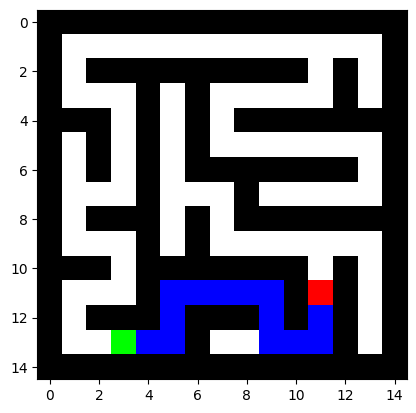

In [6]:
# process with the task
DATASET_PROMPTS: list[list[str]]; DATASET_TARGETS: list[str]
DATASET_PROMPTS, DATASET_TARGETS = LOGIT_ATTRIBUTION_TASK(DATASET_TOKENS)

DATASET_PROMPTS_JOINED: list[str] = [" ".join(prompt) for prompt in DATASET_PROMPTS]
DATASET_TARGET_IDS: Float[torch.Tensor, "n_mazes"] = torch.tensor(TOKENIZER.encode(DATASET_TARGETS), dtype=torch.long).cpu()

print("for first maze:")
print(f"full:\n{' '.join(DATASET_PROMPTS[0])}")
print(f"prompt:\n{'[...] ' + DATASET_PROMPTS_JOINED[0][-150:]}")
print(f"target:\n{DATASET_TARGETS[0]}")
print(f"target id:\n{DATASET_TARGET_IDS[0]}")
plt.imshow(DATASET[0].as_pixels())

n_mazes: int = len(DATASET_TOKENS)
d_vocab: int = TOKENIZER.vocab_size

# run model

In [7]:
LOGITS: Float[torch.Tensor, "n_mazes seq_len d_vocab"]
CACHE: ActivationCache

LOGITS, CACHE = MODEL.run_with_cache(DATASET_PROMPTS_JOINED)

In [8]:
print(f"{n_mazes = }, {d_vocab = }")
print(f"{LOGITS.shape = }")
cache_shapes: dict[str, tuple[int, ...]] = {k: v.shape for k, v in CACHE.items()}
print(f"{cache_shapes = }")

n_mazes = 10, d_vocab = 60
LOGITS.shape = torch.Size([10, 227, 60])
cache_shapes = {'hook_embed': torch.Size([10, 227, 256]), 'hook_pos_embed': torch.Size([10, 227, 256]), 'blocks.0.hook_resid_pre': torch.Size([10, 227, 256]), 'blocks.0.ln1.hook_scale': torch.Size([10, 227, 1]), 'blocks.0.ln1.hook_normalized': torch.Size([10, 227, 256]), 'blocks.0.attn.hook_q': torch.Size([10, 227, 16, 16]), 'blocks.0.attn.hook_k': torch.Size([10, 227, 16, 16]), 'blocks.0.attn.hook_v': torch.Size([10, 227, 16, 16]), 'blocks.0.attn.hook_attn_scores': torch.Size([10, 16, 227, 227]), 'blocks.0.attn.hook_pattern': torch.Size([10, 16, 227, 227]), 'blocks.0.attn.hook_z': torch.Size([10, 227, 16, 16]), 'blocks.0.hook_attn_out': torch.Size([10, 227, 256]), 'blocks.0.hook_resid_mid': torch.Size([10, 227, 256]), 'blocks.0.ln2.hook_scale': torch.Size([10, 227, 1]), 'blocks.0.ln2.hook_normalized': torch.Size([10, 227, 256]), 'blocks.0.mlp.hook_pre': torch.Size([10, 227, 1024]), 'blocks.0.mlp.hook_post': torch.Size

we expect the logits to have shape `(n_mazes, n_tokens, n_vocab)`


## get and evaluate predictions

these should have shape `(n_mazes, n_vocab)`

In [9]:
LAST_TOK_LOGITS: Float[torch.Tensor, "n_mazes d_vocab"] = LOGITS[:, -1, :].cpu()
print(f"{LAST_TOK_LOGITS.shape = }")

LAST_TOK_LOGITS.shape = torch.Size([10, 60])


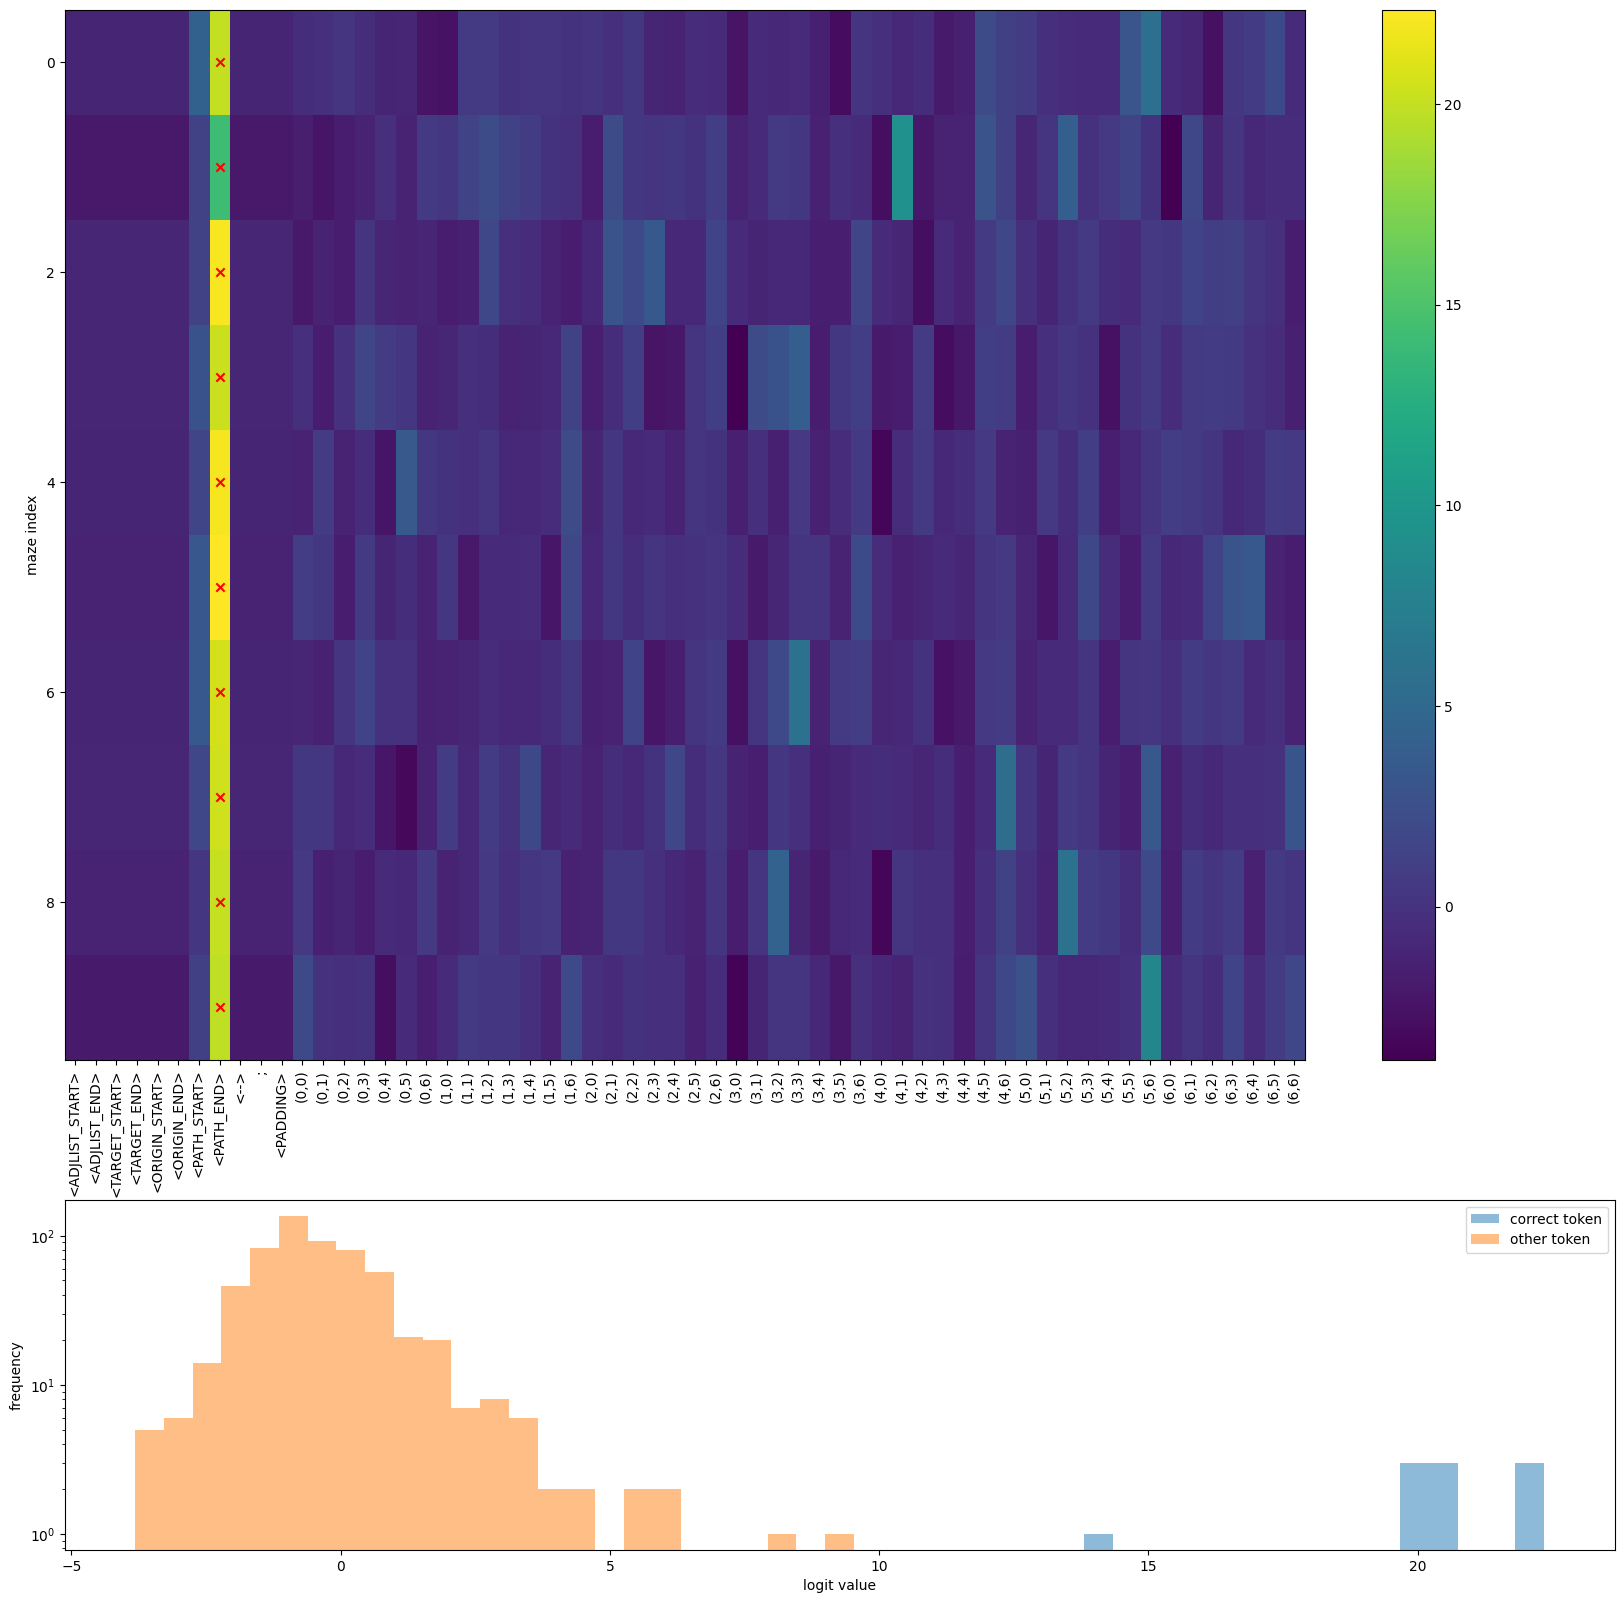

In [10]:
plot_logits(
    last_tok_logits=LAST_TOK_LOGITS,
    target_idxs=DATASET_TARGET_IDS,
    tokenizer=TOKENIZER,
    n_bins=50,
    density=False,
    logy=True,
    show=False,
)
plt.show()

In [11]:
PREDICTED_TOKENS: list[str] = TOKENIZER.decode(LAST_TOK_LOGITS.argmax(dim=-1).tolist())
print(f"{len(PREDICTED_TOKENS) = }")
print(f"{DATASET_TARGETS[0] = }")
print(f"{PREDICTED_TOKENS[0] = }")

len(PREDICTED_TOKENS) = 10
DATASET_TARGETS[0] = '<PATH_END>'
PREDICTED_TOKENS[0] = '<PATH_END>'


## overall accuracy

In [12]:
prediction_correct: Bool[torch.Tensor, "n_mazes"] = torch.tensor([
	pred == target 
	for pred, target in zip(PREDICTED_TOKENS, DATASET_TARGETS)
])

# print(f"{prediction_correct.shape = }")
print(f"{prediction_correct.float().mean().item() = }")

prediction_correct.float().mean().item() = 1.0


# Results

## logit diff

A logit difference $d$ can be interpreted as the model being $e^{d}$ times more likely to choose the correct response. Here, the `test` column tells us what token we are comparing: `taget` (correct) token, `predicted` (argmax sample) token, and `sampled` (sampled from logits) token. Also included are `noise={p}` (predicted with gaussian noise added to logits) and `random_r{i}` (a fully random one-hot vector). We compare these to either `all` other logits, or a `random` other vector.

           test compare_to  result_orig  result_res       diff     ratio
0        target        all    40.363132   18.212540  22.150593  2.216228
1     predicted        all    40.363132   18.212540  22.150593  2.216228
2       sampled        all    40.363132   18.212540  22.150593  2.216228
3    noise=1.00        all    40.363132   18.212540  22.150593  2.216228
4    noise=2.00        all    40.363132   18.212540  22.150593  2.216228
5    noise=3.00        all    40.363132   18.212540  22.150593  2.216228
6    noise=5.00        all    40.363132   18.212540  22.150593  2.216228
7   noise=10.00        all    13.409552    4.166465   9.243087  3.218448
8     random_r0        all     1.825123    1.603510   0.221613  1.138205
9        target     random    20.728710   20.933666  -0.204956  0.990209
10    predicted     random    20.728710   20.933666  -0.204956  0.990209
11      sampled     random    20.728710   20.933666  -0.204956  0.990209
12   noise=1.00     random    20.728710   20.933666

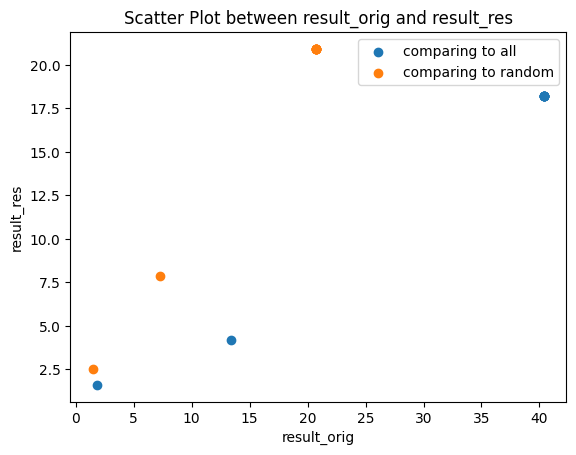

In [13]:
LOGIT_DIFF_DF: pd.DataFrame = logits_diff_multi(
	model=MODEL,
	cache=CACHE,
	dataset_target_ids=DATASET_TARGET_IDS,
	last_tok_logits=LAST_TOK_LOGITS,
	# noise_sigmas=np.logspace(0, 3, 100),
)

print(LOGIT_DIFF_DF)

# scatter separately for "all" vs "random"
fig, ax = plt.subplots()
for compare_to in ["all", "random"]:
	df = LOGIT_DIFF_DF[LOGIT_DIFF_DF["compare_to"] == compare_to]
	ax.scatter(
		df['result_orig'], df['result_res'], 
		label=f"comparing to {compare_to}",
		marker='o',
	)
ax.legend()
plt.xlabel('result_orig')
plt.ylabel('result_res')
plt.title('Scatter Plot between result_orig and result_res')
plt.show()


## logit lens

Here, we test the logit difference of the correct token at various layers

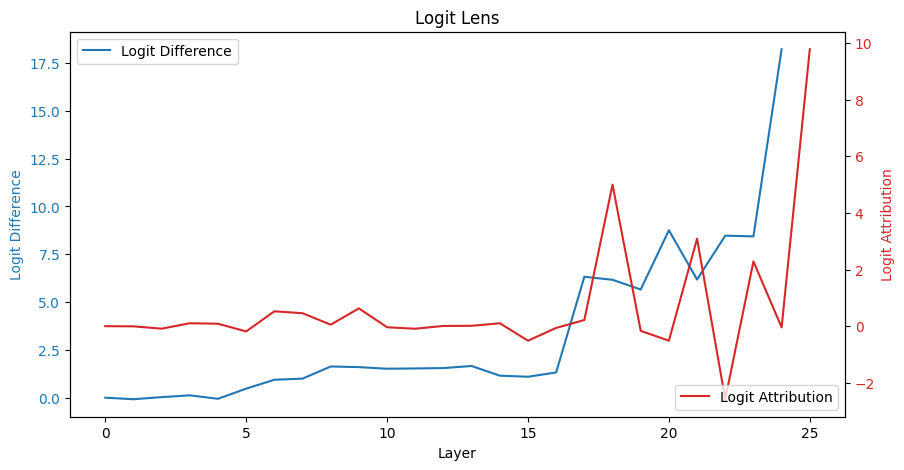

In [14]:
figax, results = plot_logit_lens(
    model=MODEL,
    cache=CACHE,
    answer_tokens=DATASET_TARGET_IDS,
    show=False,
)
plt.show()

## direct logit attribution

answer_tokens.shape = torch.Size([10])
n_layers = 12, n_heads = 16, d_model = 256
n_layers * n_heads = 192
n_layers * mlp_dim = 12288
Tried to stack head results when they weren't cached. Computing head results now
per_head_residual.shape = torch.Size([192, 10, 256])
per_head_logit_diffs.shape = torch.Size([192])
per_head_logit_diffs.shape = torch.Size([12, 16])
per_neuron_residual.shape = torch.Size([12288, 10, 256])
per_neuron_logit_diffs.shape = torch.Size([12288])
per_neuron_logit_diffs.shape = torch.Size([12, 1024])


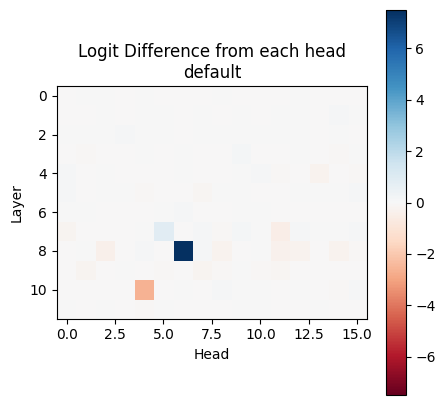

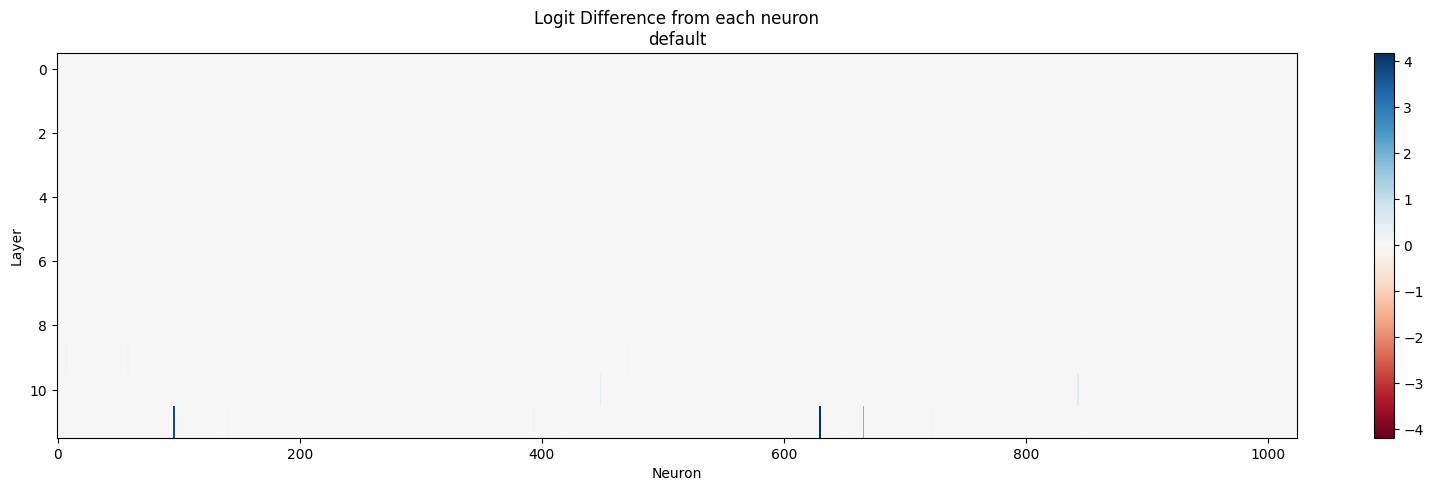

In [15]:
fig, ax, DLA_DATA = plot_direct_logit_attribution(
	model=MODEL,
	cache=CACHE,
    answer_tokens=DATASET_TARGET_IDS,
    show=False,
)
plt.show()

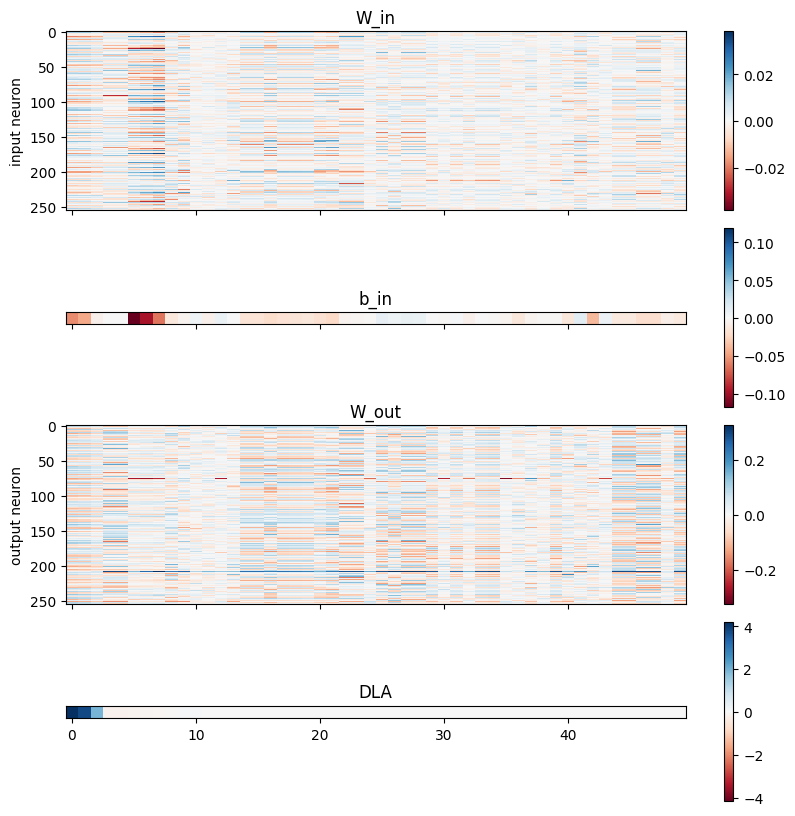

(<Figure size 1000x1000 with 8 Axes>,
 array([<Axes: title={'center': 'W_in'}, ylabel='input neuron'>,
        <Axes: title={'center': 'b_in'}>,
        <Axes: title={'center': 'W_out'}, ylabel='output neuron'>,
        <Axes: title={'center': 'DLA'}>], dtype=object))

In [16]:
plot_important_neurons(
    MODEL,
    layer=-1,
    neuron_dla_data=DLA_DATA["neurons"],
    n_important_neurons=50,
)

important_heads = [(8, 6, 7.4925127), (10, 4, -2.5813243), (7, 5, 0.8615473), (7, 11, -0.47958732), (8, 2, -0.40561467)]
CACHE.keys() = dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', '

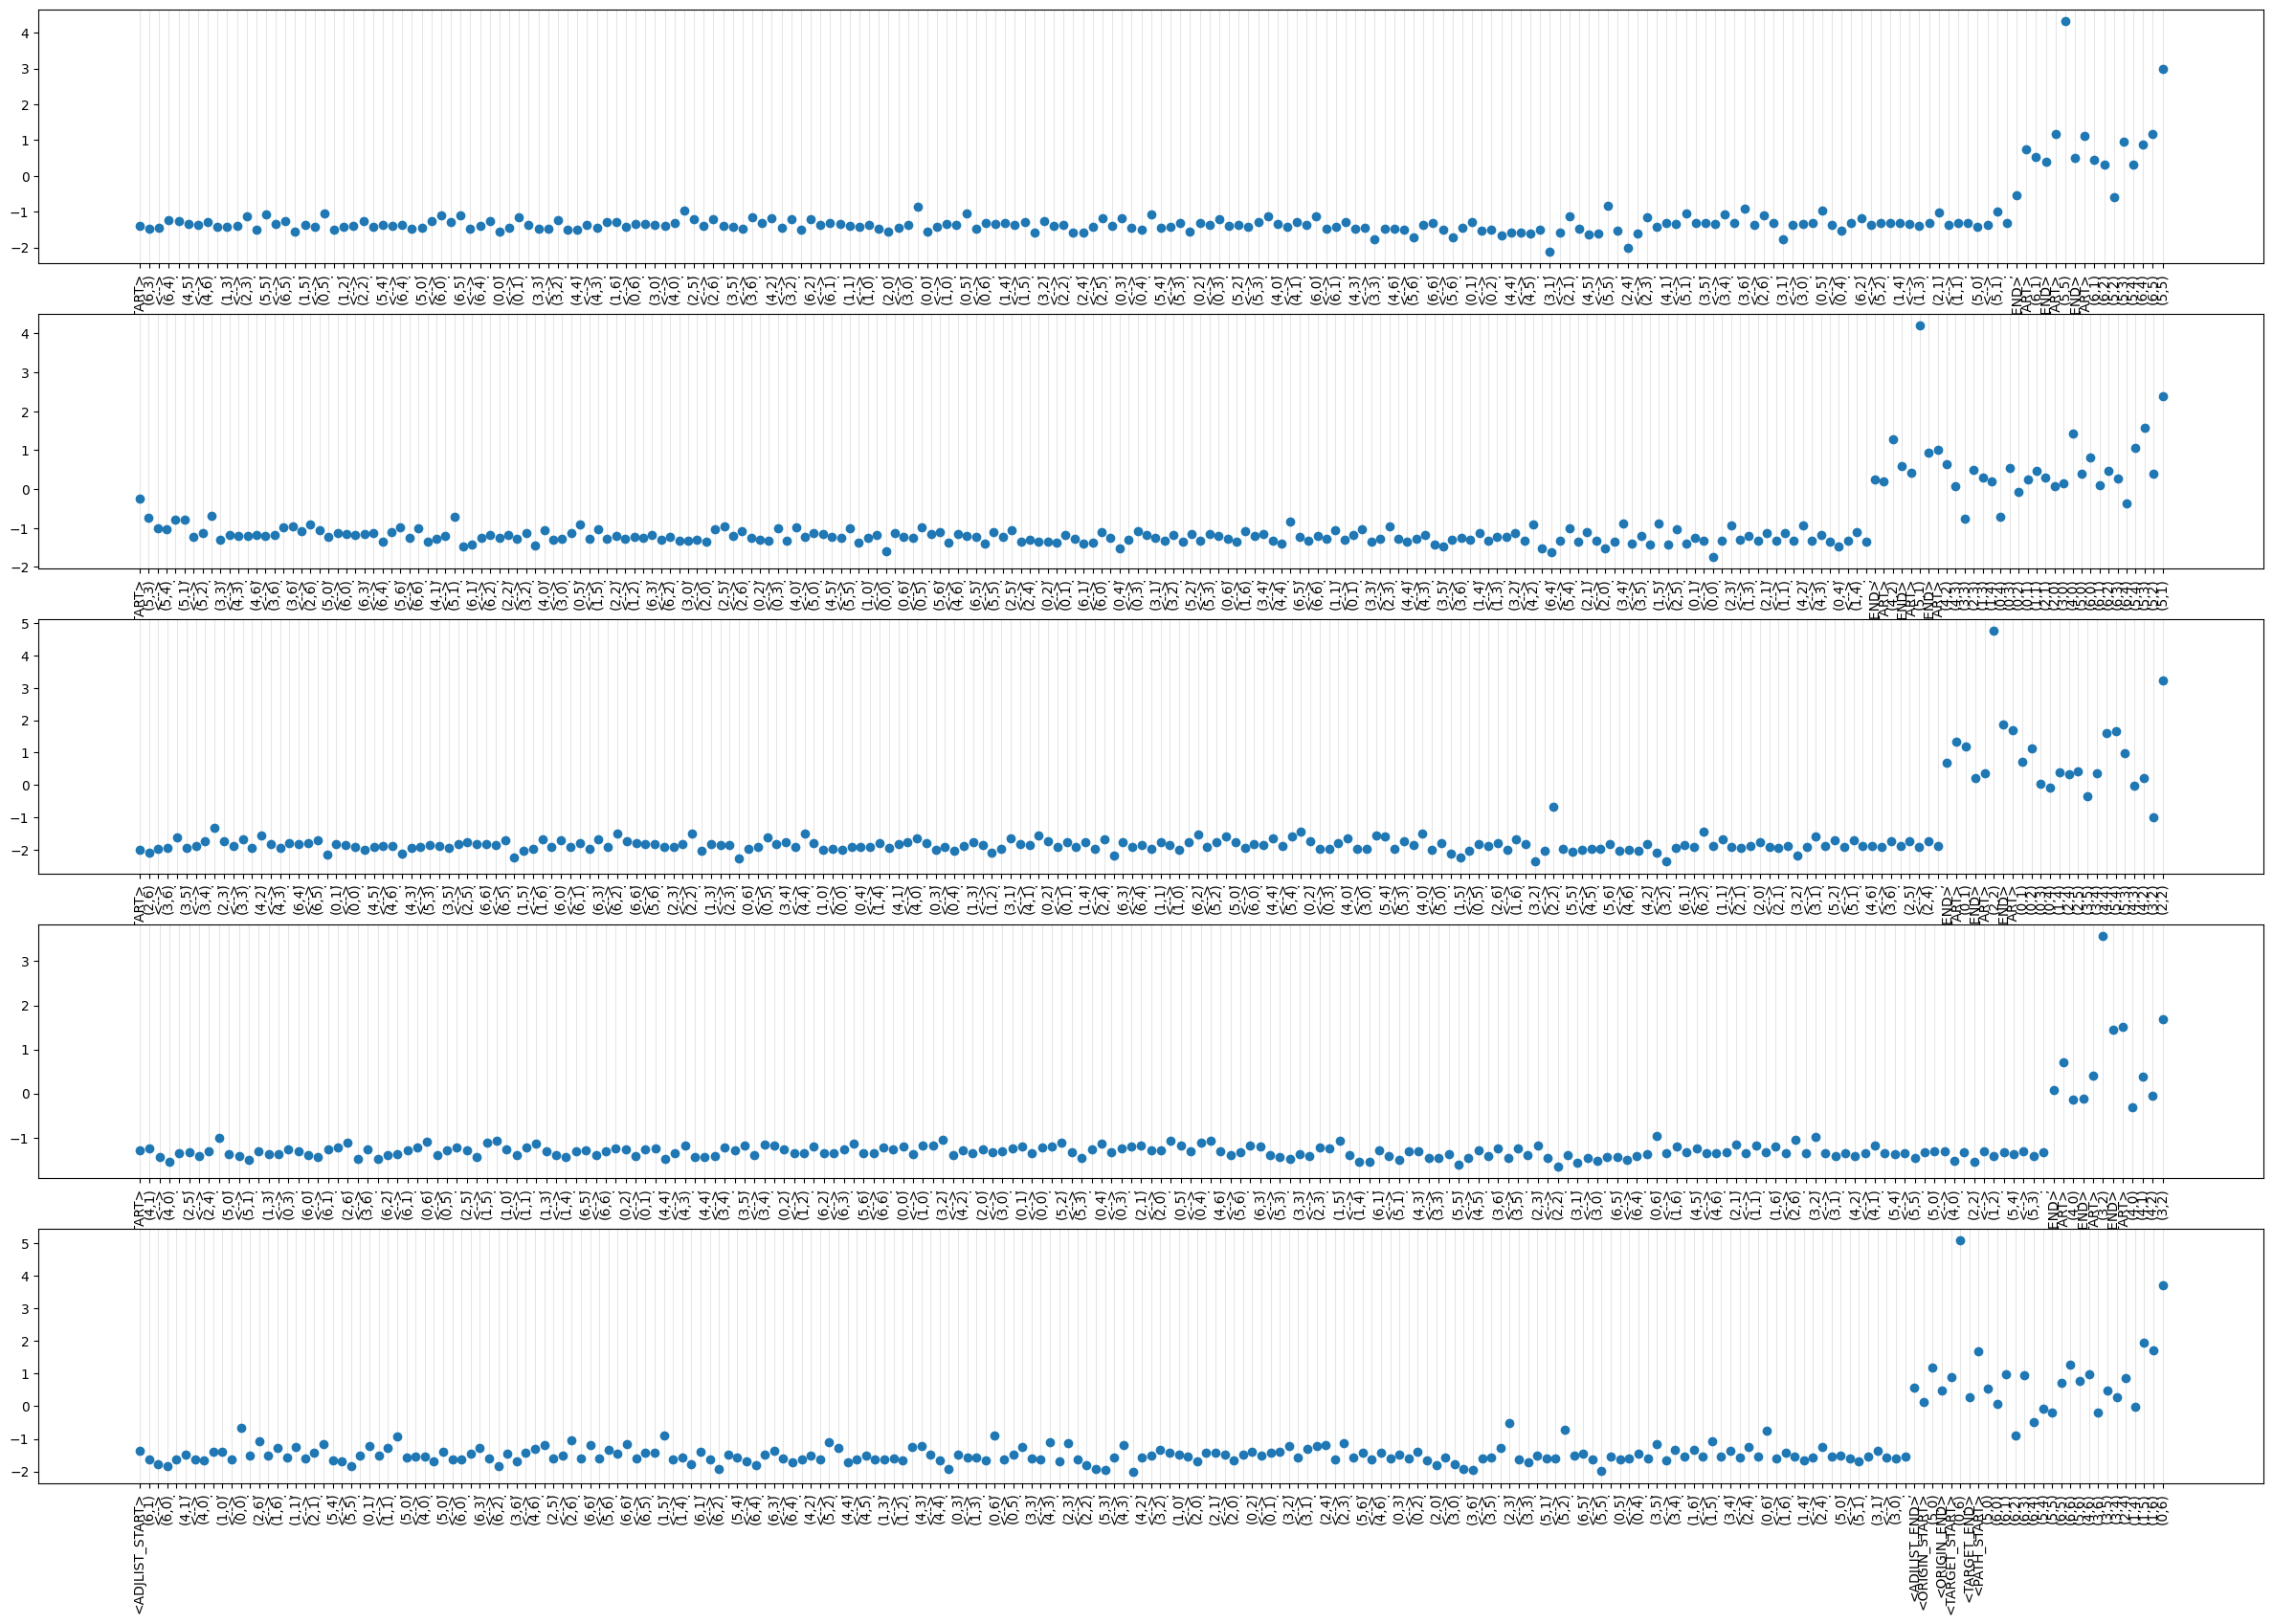

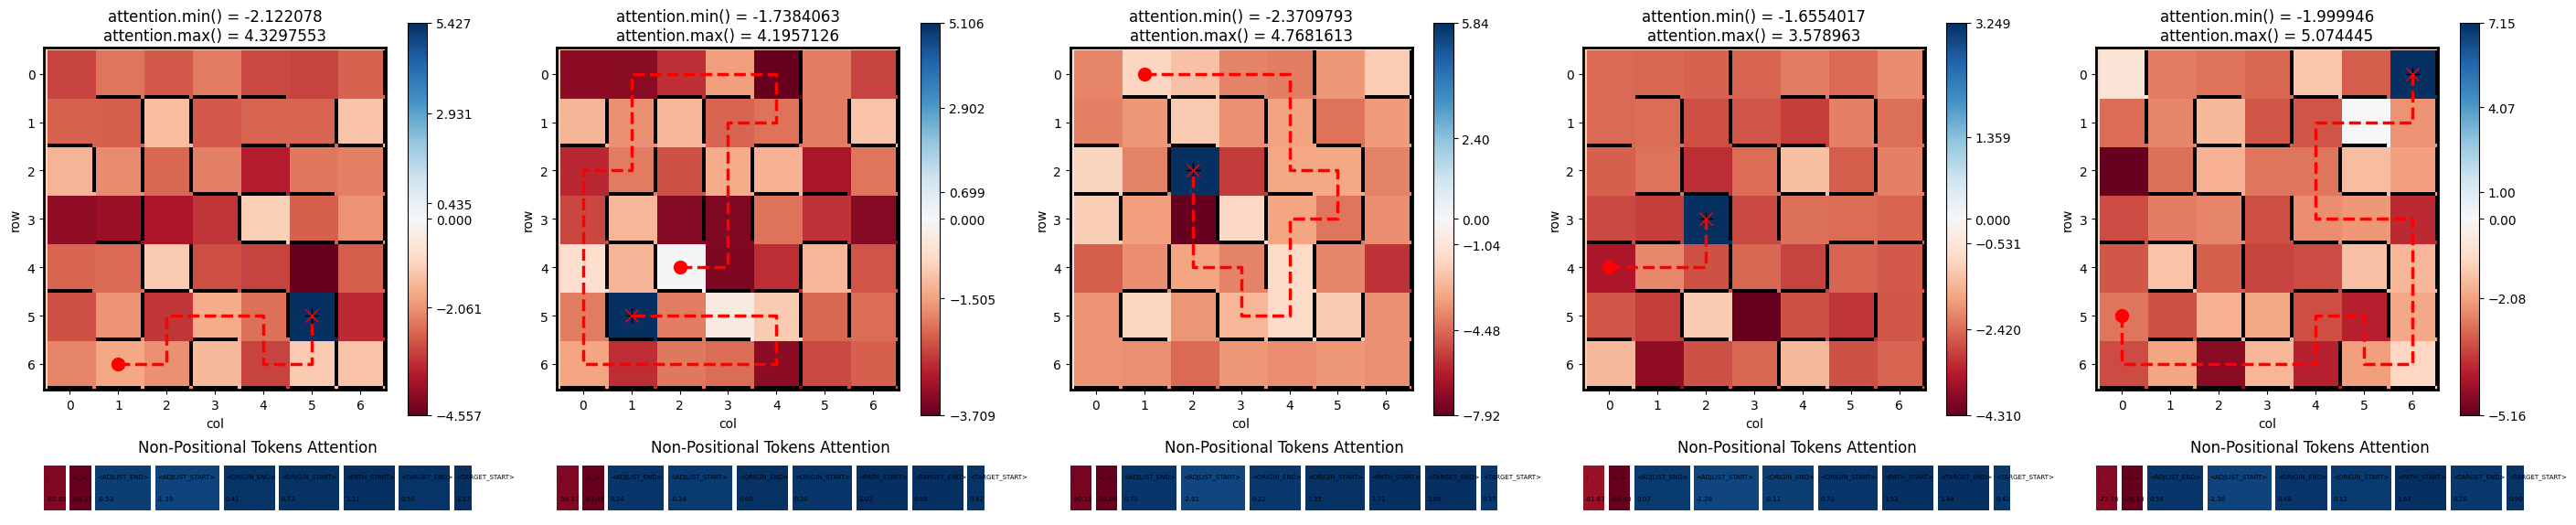

--------------------------------------------------------------------------------
head: layer_10.head_4, score: c = -2.5813243, v.shape = (10, 227, 227)
(5,0) <--> (5,1) ; <ADJLIST_END> <ORIGIN_START> (6,1) <ORIGIN_END> <TARGET_START> (5,5) <TARGET_END> <PATH_START> (6,1) (6,2) (5,2) (5,3) (5,4) (6,4) (6,5) (5,5)
-1.8  -1.9 -2.0    0.1           1.7            2.2   0.4          1.4            8.8   1.6          0.8          2.2   1.4   0.6   1.9   0.3   1.1   -0.1  4.0   
(1,4) (0,4) (0,3) (0,2) (0,1) (1,1) (2,1) (2,0) (3,0) (4,0) (5,0) (6,0) (6,1) (6,2) (6,3) (6,4) (5,4) (5,3) (5,2) (5,1)
1.0   1.2   1.5   1.5   0.7   1.6   2.5   1.8   1.4   2.5   1.6   2.0   2.2   2.2   2.7   1.9   2.0   2.1   0.6   3.0   
<TARGET_START> (2,2) <TARGET_END> <PATH_START> (0,1) (0,2) (0,3) (0,4) (1,4) (2,4) (2,5) (3,5) (3,4) (4,4) (5,4) (5,3) (4,3) (4,2) (3,2) (2,2)
0.9            9.8   3.2          1.3          0.5   1.3   2.0   0.6   1.0   0.5   1.2   0.6   0.9   2.3   2.5   0.5   0.3   -0.2  1.3   5.

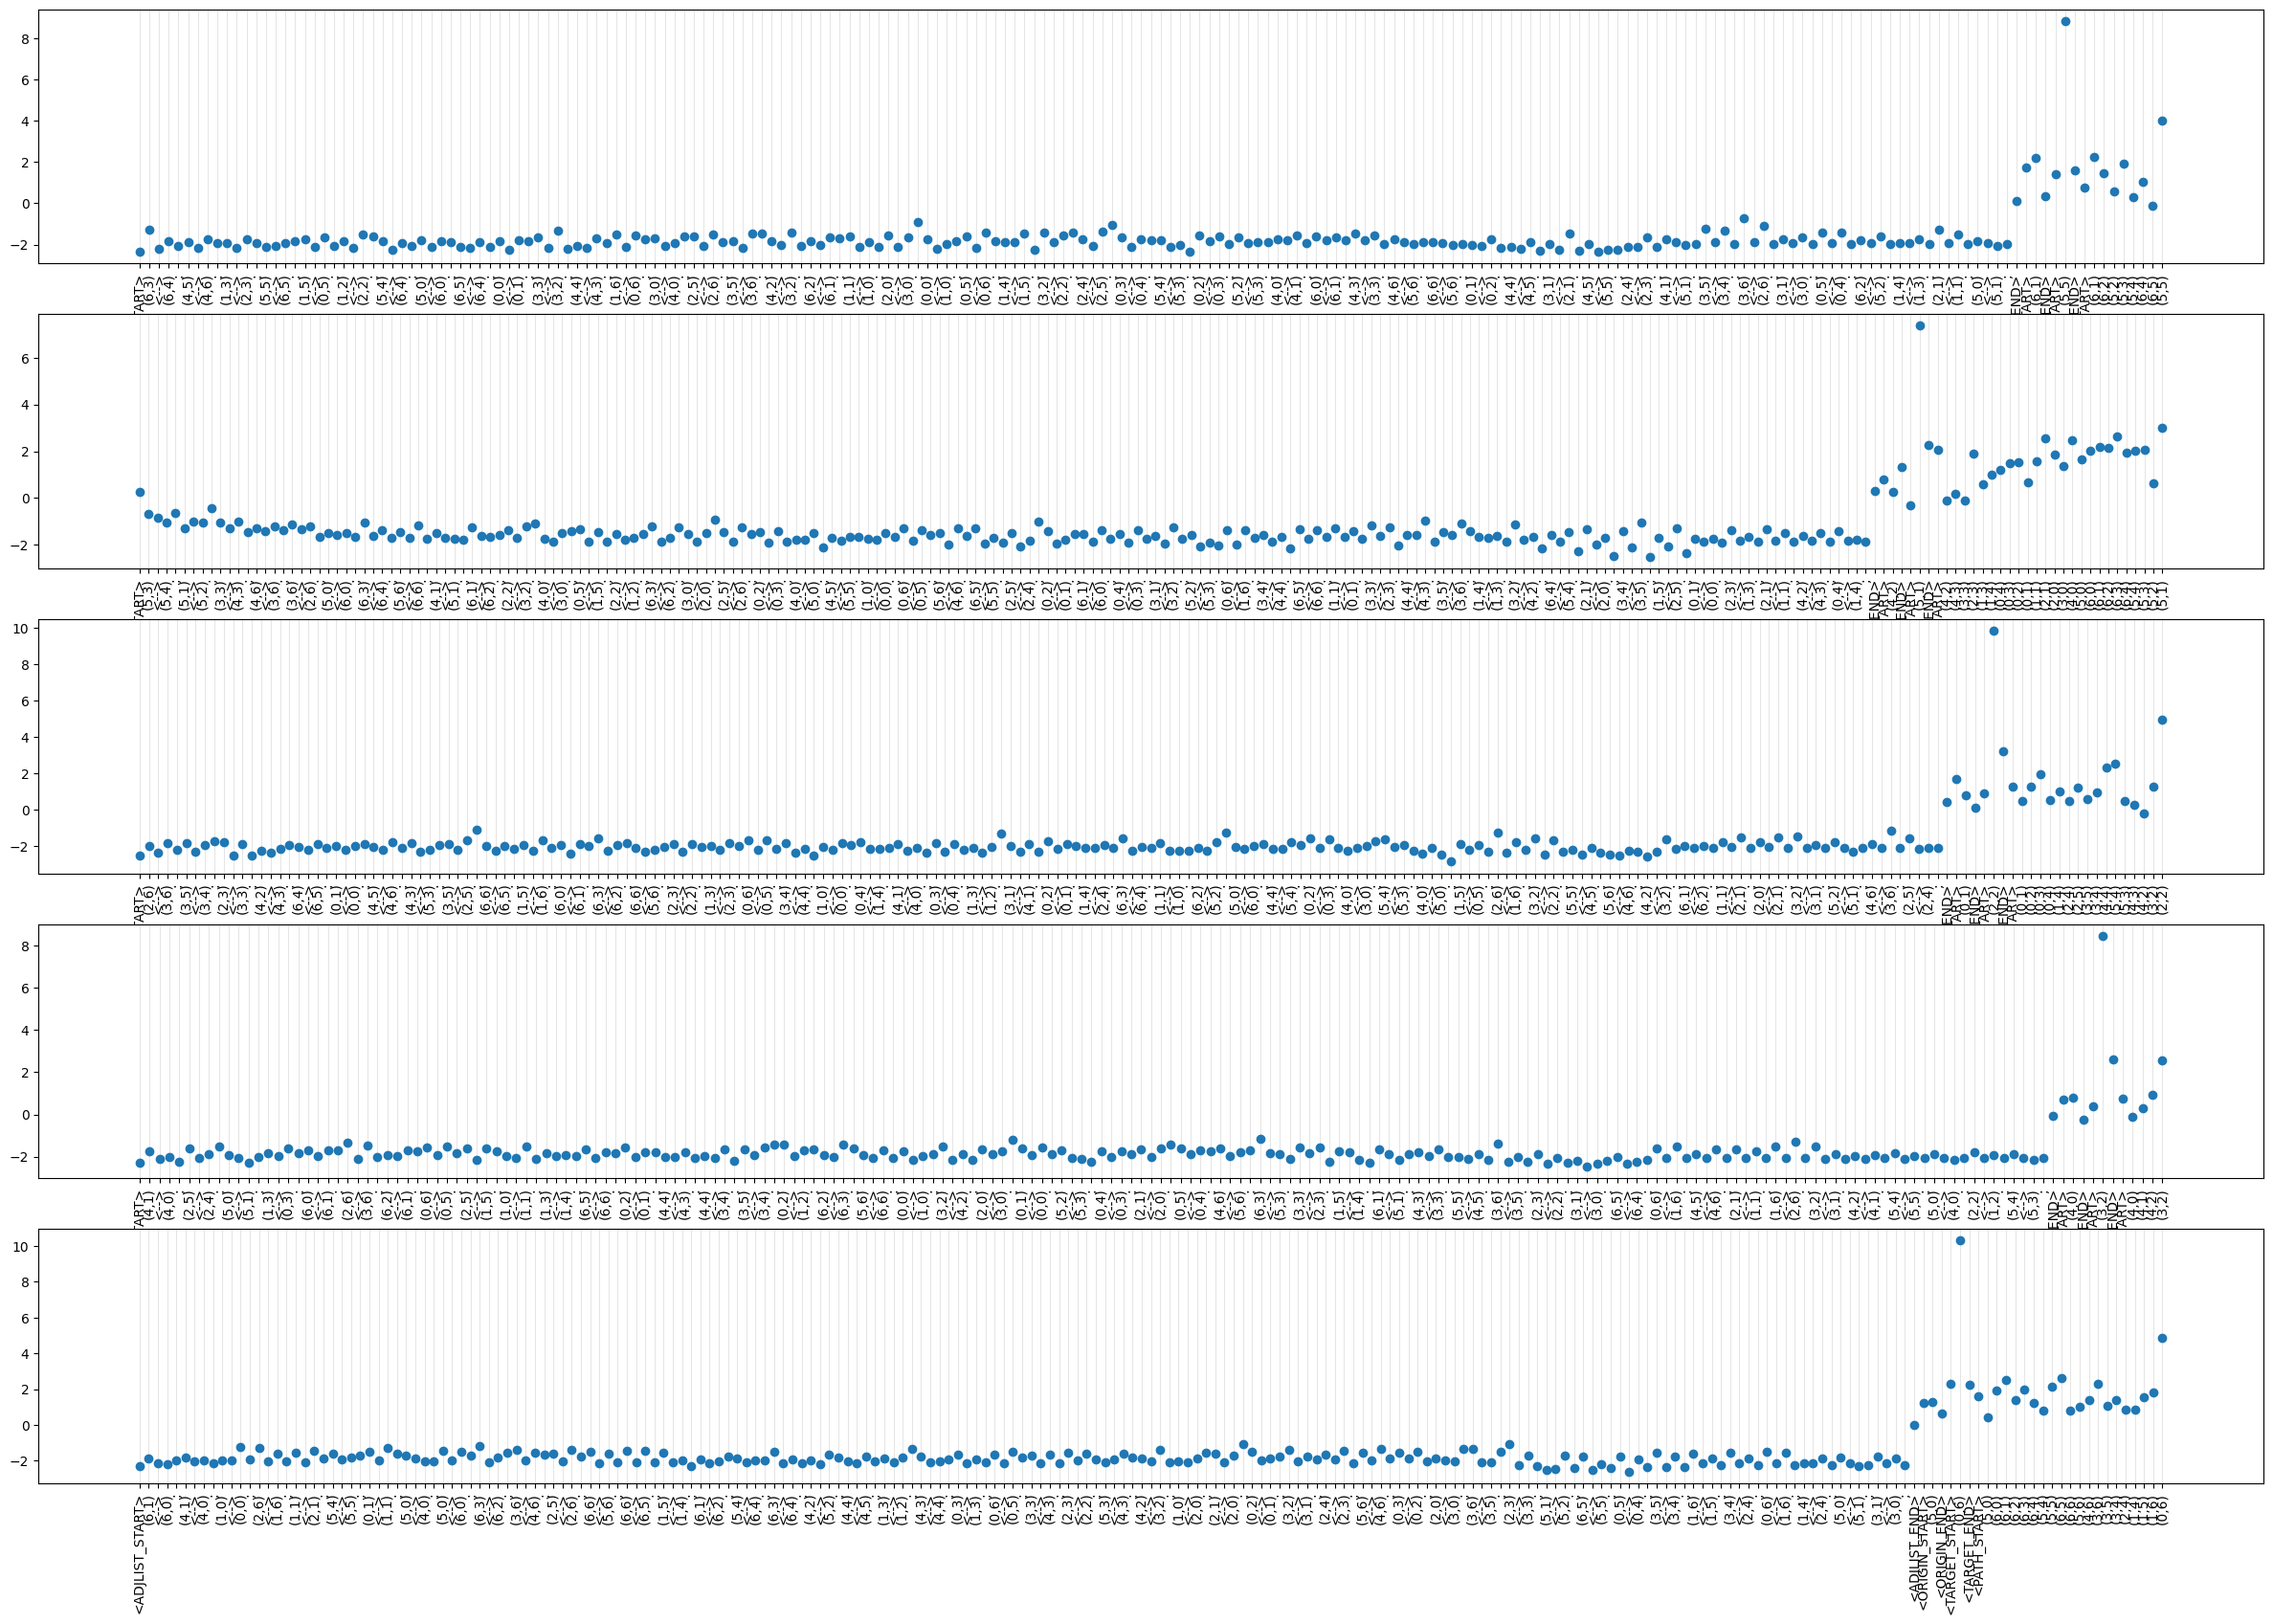

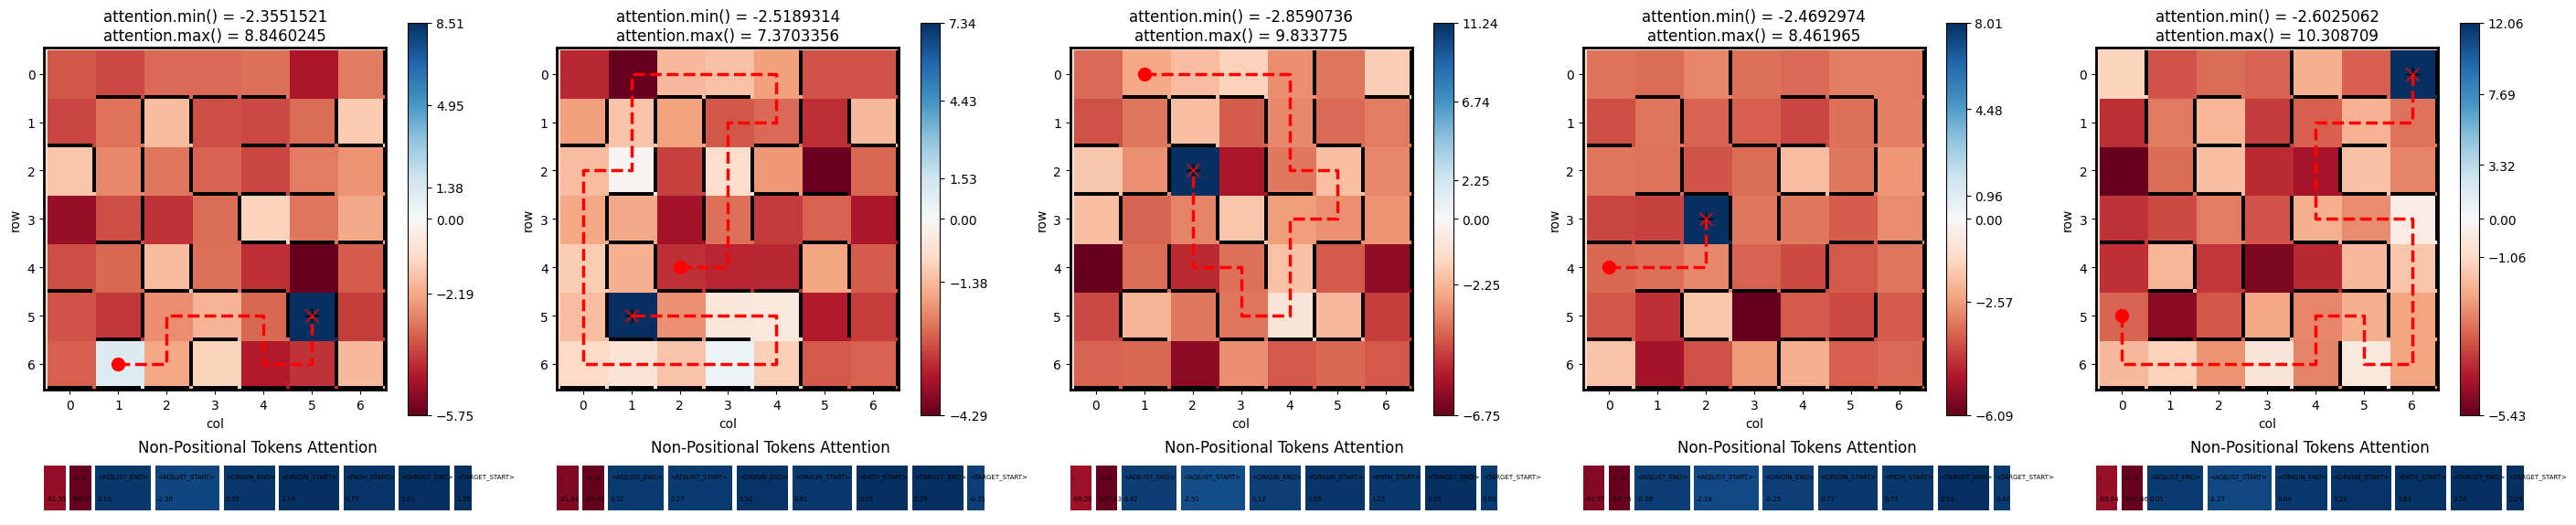

--------------------------------------------------------------------------------
head: layer_7.head_5, score: c = 0.8615473, v.shape = (10, 227, 227)
(5,0) <--> (5,1) ; <ADJLIST_END> <ORIGIN_START> (6,1) <ORIGIN_END> <TARGET_START> (5,5) <TARGET_END> <PATH_START> (6,1) (6,2) (5,2) (5,3) (5,4) (6,4) (6,5) (5,5)
-1.8  -1.6 -1.5    -0.1          0.6            0.4   0.2          0.8            3.2   1.0          1.7          0.5   0.1   0.6   0.7   1.3   1.2   1.5   1.9   
(1,4) (0,4) (0,3) (0,2) (0,1) (1,1) (2,1) (2,0) (3,0) (4,0) (5,0) (6,0) (6,1) (6,2) (6,3) (6,4) (5,4) (5,3) (5,2) (5,1)
0.7   0.0   0.2   0.6   0.5   1.0   1.1   -0.2  -0.2  0.2   -0.4  -0.1  -0.1  0.0   -0.0  0.7   1.6   1.0   1.3   1.6   
<TARGET_START> (2,2) <TARGET_END> <PATH_START> (0,1) (0,2) (0,3) (0,4) (1,4) (2,4) (2,5) (3,5) (3,4) (4,4) (5,4) (5,3) (4,3) (4,2) (3,2) (2,2)
0.9            2.8   1.7          1.6          0.7   0.5   0.4   0.3   0.9   0.7   1.0   0.9   1.4   0.8   1.0   0.1   -0.0  -0.1  0.7   1.4 

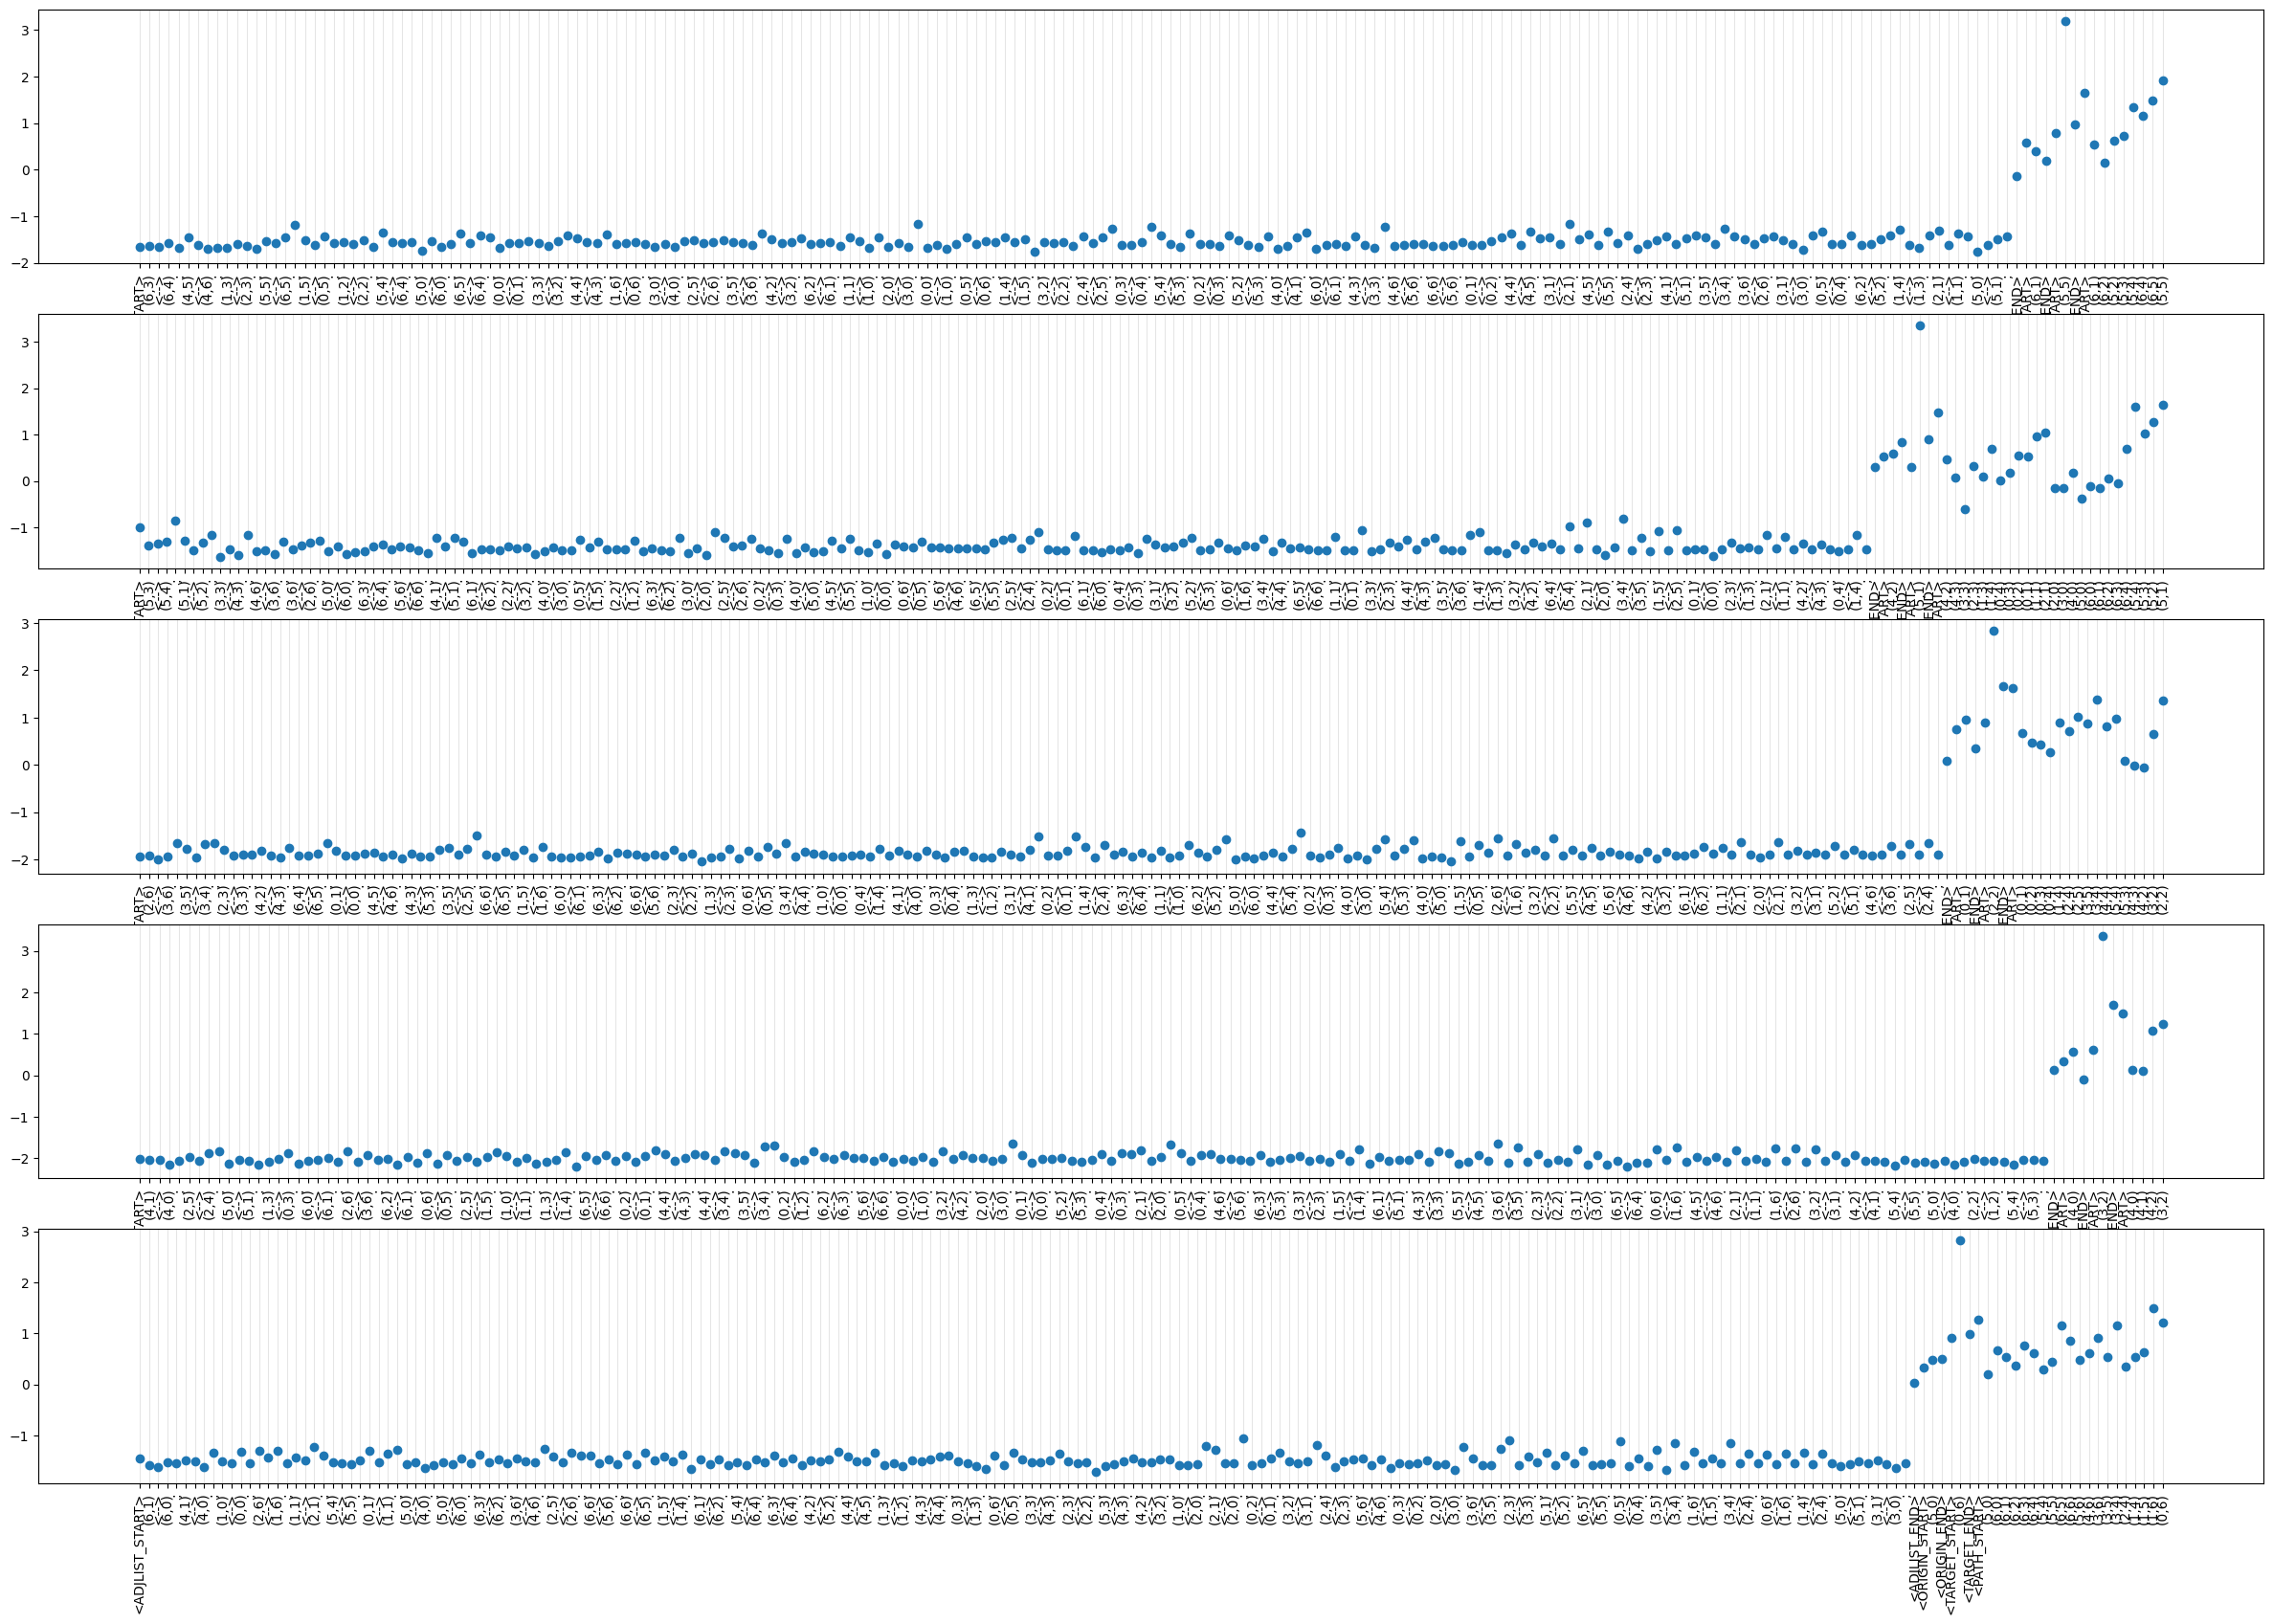

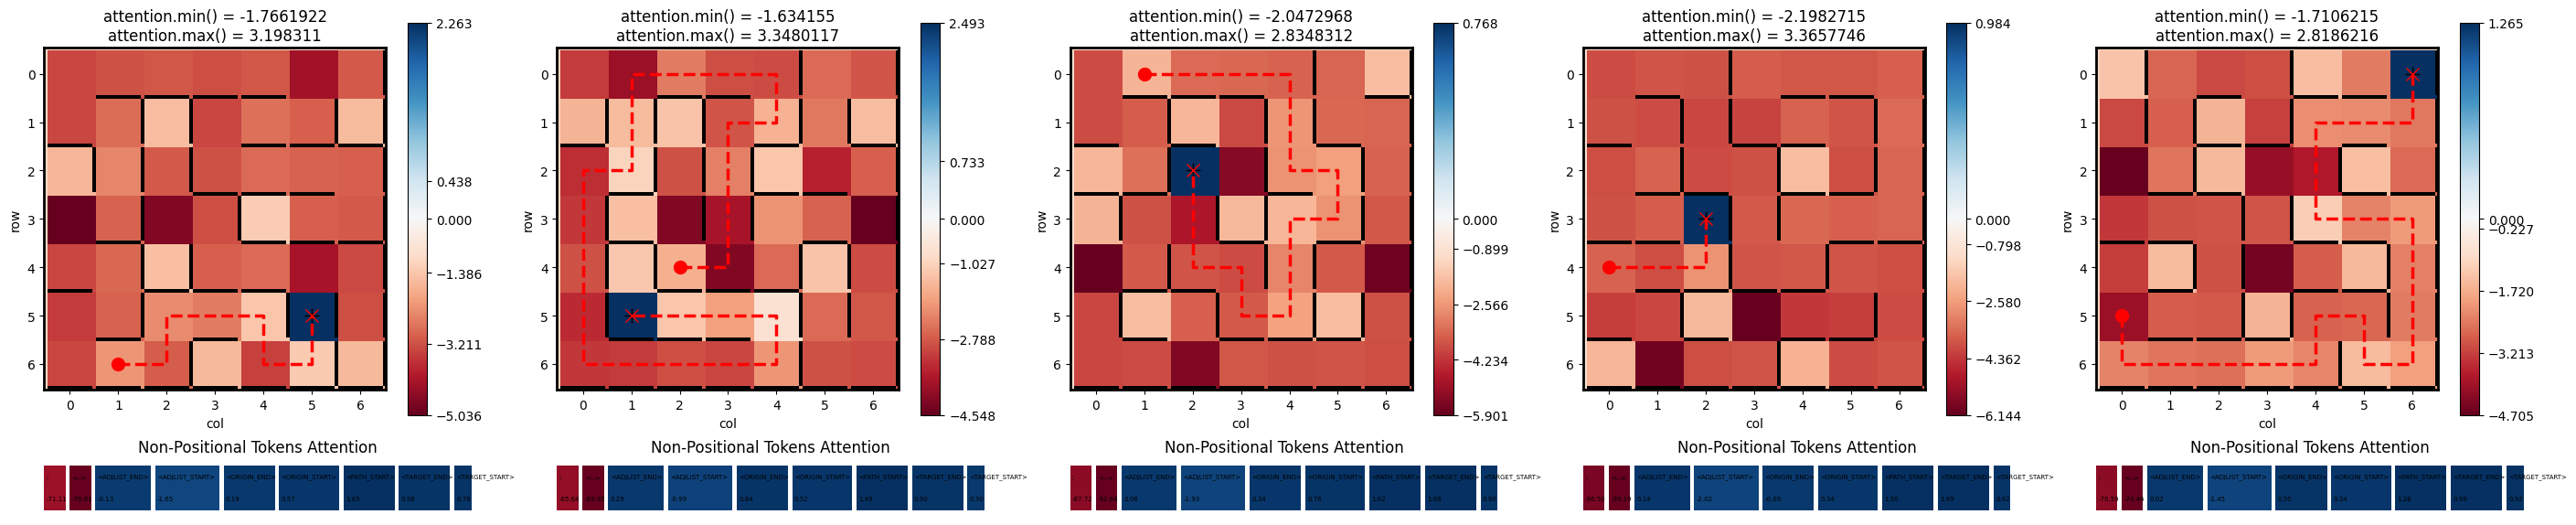

--------------------------------------------------------------------------------
head: layer_7.head_11, score: c = -0.47958732, v.shape = (10, 227, 227)
(5,0) <--> (5,1) ; <ADJLIST_END> <ORIGIN_START> (6,1) <ORIGIN_END> <TARGET_START> (5,5) <TARGET_END> <PATH_START> (6,1) (6,2) (5,2) (5,3) (5,4) (6,4) (6,5) (5,5)
-1.9  -1.9 -1.9    -0.7          0.8            0.6   -0.4         0.7            3.1   0.4          1.3          0.8   0.1   0.4   0.7   1.3   1.2   2.0   1.5   
(1,4) (0,4) (0,3) (0,2) (0,1) (1,1) (2,1) (2,0) (3,0) (4,0) (5,0) (6,0) (6,1) (6,2) (6,3) (6,4) (5,4) (5,3) (5,2) (5,1)
0.3   0.6   0.9   1.0   0.9   0.4   0.4   0.5   0.3   0.7   0.5   0.5   0.6   0.3   1.0   0.7   1.3   0.5   0.4   0.5   


ValueError: Please pass colormap_center value between -4.74726414680481 and -0.4367552399635315

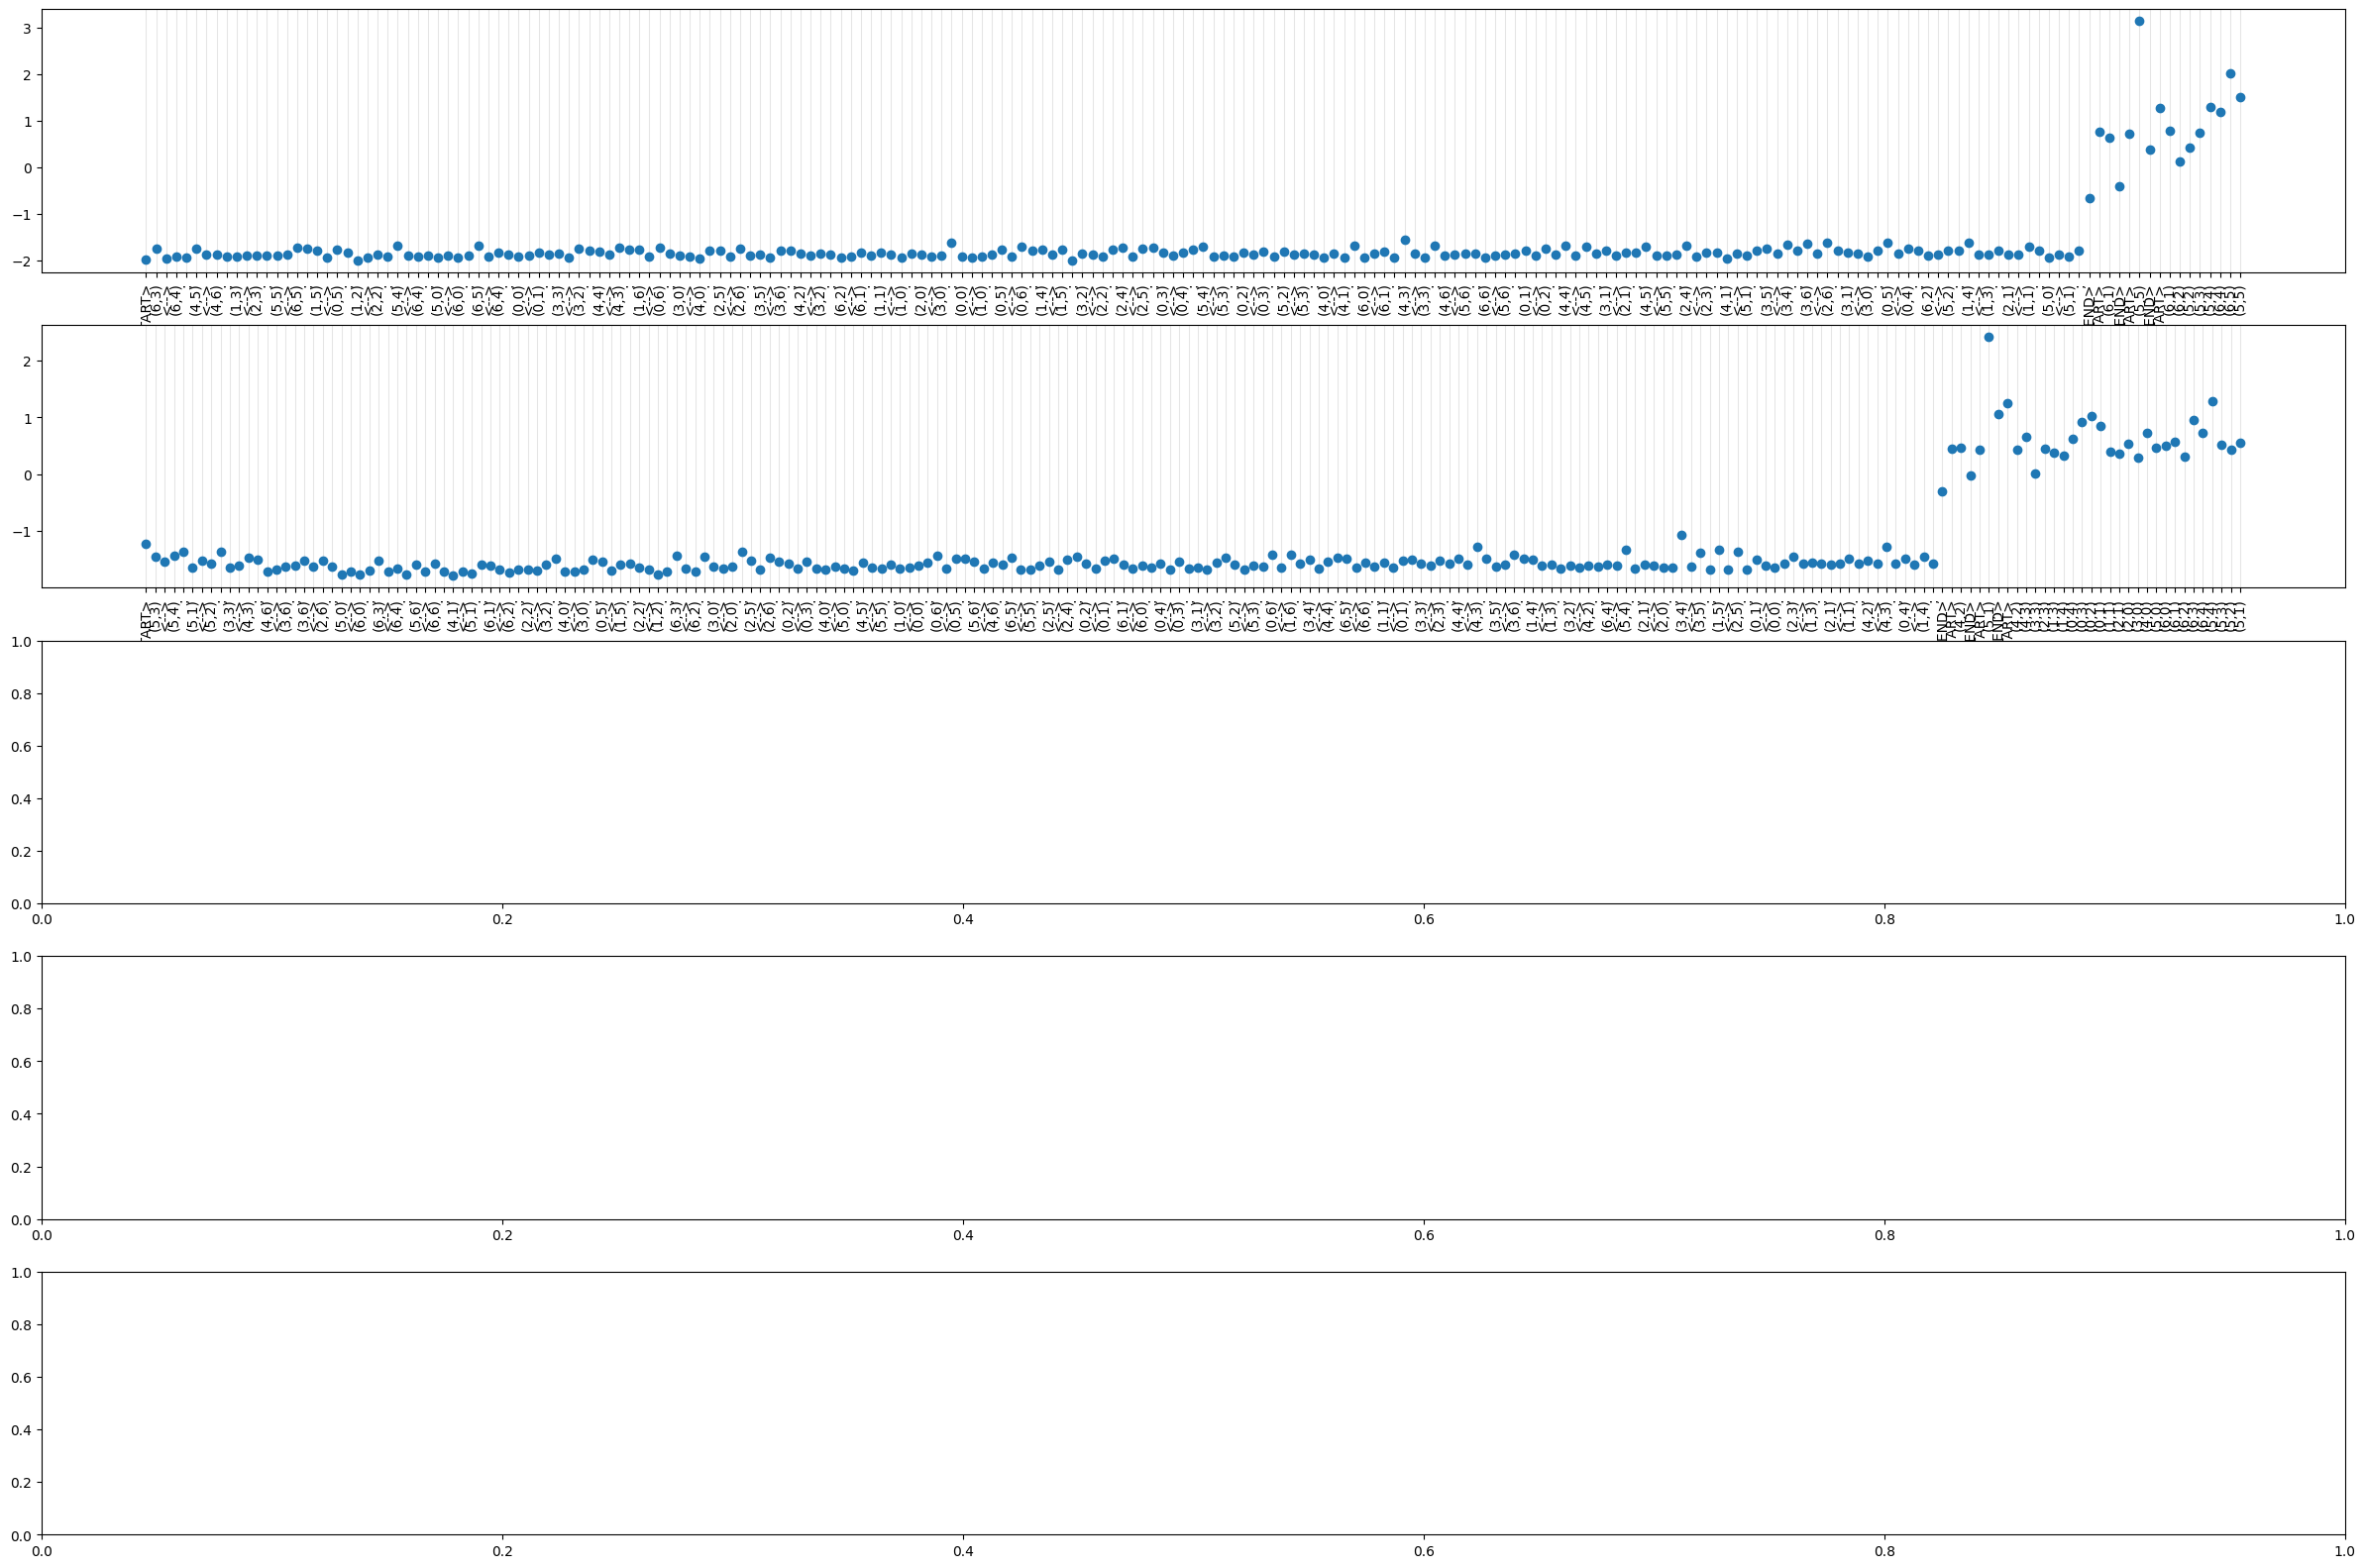

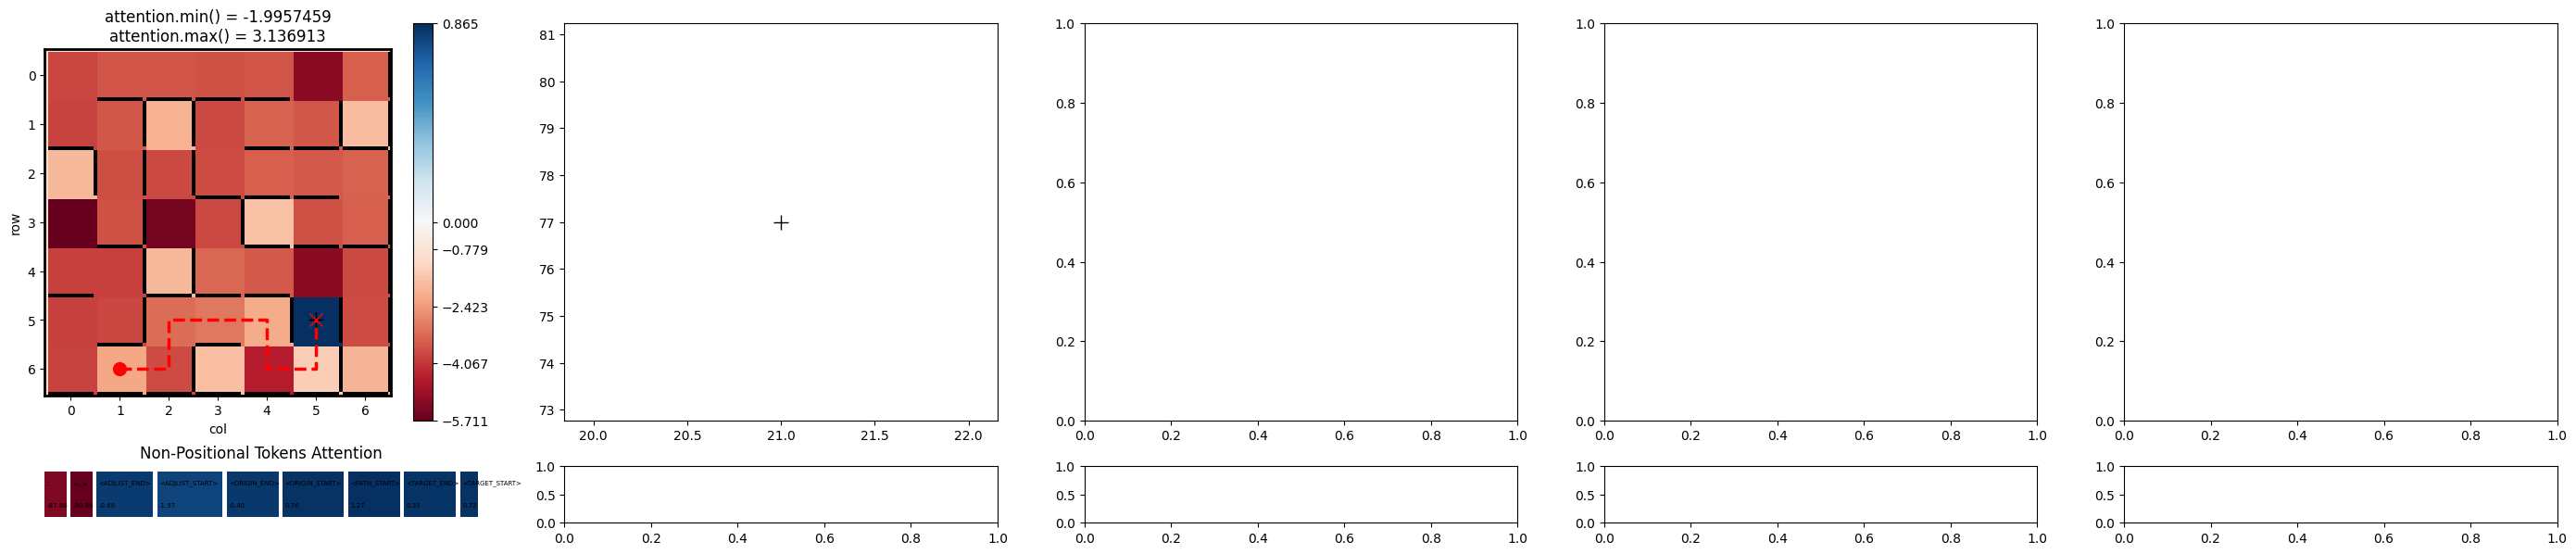

In [17]:
# let's try to plot the values of the attention heads for the top and bottom n contributing heads
# (layer, head, value)
top_heads: int = 5
important_heads: list[tuple[int, int, float]] = sorted(
    [
        (i, j, DLA_DATA["heads"][i, j])
        for i in range(DLA_DATA["heads"].shape[0])
        for j in range(DLA_DATA["heads"].shape[1])
	],
    key=lambda x: abs(x[2]),
    reverse=True,
)[:top_heads]
print(f"{important_heads = }")

# plot the attention heads
print(f"{CACHE.keys() = }")
important_heads_scores = {
    f"layer_{i}.head_{j}": (
        c,
        CACHE[f'blocks.{i}.attn.hook_attn_scores'][:, j, :, :].cpu().numpy(),
    )
    for i, j, c in important_heads
}

print("="*80)

attn_final_tok_output = plot_attention_final_token(
    important_heads_scores=important_heads_scores,
    prompts=DATASET_PROMPTS,
    targets=DATASET_TARGETS,
    mazes=DATASET,
    tokenizer=TOKENIZER,
    n_mazes=5,
    last_n_tokens=20,
    exponentiate_scores=False,
    plot_colored_tokens=True,
    plot_scores=True,
    maze_colormap_center=0.0,
    show_all=True,
)


# TODO: total attention on coords within path as opposed to not in path?